In [1]:
import os, sys, time

sys.path
sys.path.append('./')

import numpy as np

from astropy.io.fits import getdata
from astropy import wcs
from astropy.io import fits
from astropy import units as u
from astropy import constants as con
from astropy.coordinates import SkyCoord

import matplotlib
matplotlib.use('PDF')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# import aplpy

from scipy.optimize import curve_fit

In [2]:
    def plot_spectra(
                     freq_array      = np.array([]), 
                     intensity_array = np.array([]),
                     figsize         = (6,4),
                     xlabel        = 'Frequency [GHz]'    , xlabel_size = 12, xscale = 'linear',
                     ylabel        = 'Intensity [Jy/beam]', ylabel_size = 12, yscale = 'linear',
                     fontsize      = 12, 
                     plot_ticks     = True,
                       xtick_size = 12, ytick_size = 12,
                     outPDF_filename = 'none',
                     verbose = False
                    ):
        '''
        This is a function to plot 1D spectra.
        
        Input:
            freq_array [1D numpy array] : store the coordinate values in the frequency axis.
            intensity_array [1D numpy array] : store the coordinate values in the intensity axis.
            figsize : the x,y size of 1D figure
            xlabel : the label name of x-axis
            xlabel_size : the size of x label
            xscale : the scale of x-components
            xlim : limit of x-components on the axis
            ylabel : the label name of y-axis
            ylabel_size : the size of y label
            yscale : the scale of y-components
            ylim : limit of y-components on the axis
            fontsize : the size of font
            plot_ticks : the boolean of plotting ticks
             xtick_size : the size of x-ticks
             ytick_size : the size of y-ticks
            outPDF_filename : the name of output PDF file
            
            
        Keywords:
        
        Output:
        
        Example: 
            x = np.array([1, 2, 3, 4, 5])
            y = np.array([1, 1, 3, 3, 1])
            plot_spectra(x, y)
        '''
        
        if verbose == True:
            print('Plotting 1D spectra')
            
  
        # Initializing figure
        fig = plt.figure(
                         figsize = (figsize[0], figsize[1])
                        )
        ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
        
        # Set the x/y axis title and legend
        plt.xlabel(xlabel, size = xlabel_size)
        plt.ylabel(ylabel, size = ylabel_size)

        # set plot scale
        plt.xscale(xscale)
        plt.yscale(yscale)
        
        # set label fontsizes
        plt.rc('font', size = fontsize)            # controls default text sizes
        plt.rc('xtick', labelsize = xtick_size)    # fontsize of the tick labels
        plt.rc('ytick', labelsize = ytick_size)    # fontsize of the tick labels
        if (plot_ticks != True):
            fig.axis_labels.hide_x()
            fig.axis_labels.hide_y()
            fig.tick_labels.hide_x()
            fig.tick_labels.hide_y()

        # plot the data
        plt.plot(freq_array, intensity_array,
                 '-', # symbol shape
                 color=(0.7,0.7,0.2, 0.3), # (R, G, B, transparency), ranged between [0, 1]
                 linewidth = 2.0, 
                 label = "TBD"
                )
                    
        # Setting the figure legend 
        plt.legend(loc=1, fontsize=12)
        
    

        if outPDF_filename != 'none':
            fig.save(outPDF_filename, transparent=True)

In [3]:
def chisquare(y, y_err, ymodel):
    '''
    Return the chi-square given the measurements of y, y-error, and a model of the measurements y.
    
    Input:
        y [np array]      : measurements
        y_err [np array]  : measurement errors
        ymodel [np array] : a model of y 
    
    Return:
        chisquare [double] : the chi-square value
    
    '''
    
    return np.sum( ( (y - ymodel) / y_err)**2 )
    

def fit_1dgaus(
               xlabel = 'x-axis [arbitrary unit]', xlabel_size = 14.0, xscale = 'linear',
               ylabel = 'y-axis [arbitrary unit]', ylabel_size = 14.0, yscale = 'linear',
              
              ):
    '''
    This is a general use function to fit 1D Gaussian profile.
    '''
    print('Fitting 1D  gaussian')
    
    # transform the arrays to csv
    data = {'x': freq_array,
            'y': intensity_array,
            'y_err': np.zeros(len(y)) + sigma_y
           }
    df = pd.DataFrame(data)

    filename = 'spectra.csv'
    os.system('rm -rf ' + filename)
    df.to_csv(filename, index=False)

    
    # read data from csv file
    path = './'
    df_read = pd.read_csv(path + filename)

    # Equations in Section 15.2 (Fitting Data to a straight line) of W. H. Press, Numerical Receipes, 3rd ed.
    # Note that the definition of a and b is interchanged.
    S = np.sum(
               1.0 / (df_read.y_err**2)
              )
    Sx = np.sum(
                df_read.x / (df_read.y_err**2)
               )
    Sy = np.sum(
                df_read.y / (df_read.y_err**2)
               )
    Sxx = np.sum(
                 (df_read.x**2) / (df_read.y_err**2)
                )
    Sxy = np.sum(
                 (df_read.x*df_read.y) / (df_read.y_err**2)
                )
    Delta = S * Sxx - Sx**2

    popt = np.zeros(2)
    perr = np.zeros(2)

    popt[1]     = (Sxx*Sy - Sx*Sxy) / Delta
    popt[0]     = (S*Sxy - Sx*Sy)   / Delta

    perr[1]     = np.sqrt( Sxx / Delta )
    perr[0]     = np.sqrt( S / Delta )

    # plotting data and model

    # Initializing Figure ############################################
    fig = plt.figure(
                     figsize = (8, 8)
                    )
    ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
    
    # Set the x/y axis title and legend
    plt.xlabel(xlabel,xlabel_size)
    plt.ylabel(ylabel,ylabel_size)

    plt.xscale(xscale)
    plt.yscale(yscale)
    #plt.xscale('log')
    #plt.yscale('log')
    
    plt.rc('font', size=14.0)          # controls default text sizes
    plt.rc('xtick', labelsize=14.0)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14.0)    # fontsize of the tick labels
    ##################################################################

    # plot data
    plt.plot(df_read.x, df_read.y,
             'o', markersize = 2.0,
             color = (0.7, 0.3, 0.3, 0.7),
             label = "Randomly realized linear model"
            )

    # plot model
    x_sort = np.sort(df_read.x)
    ymodel = myline(x_sort, popt[0], popt[1])
    plt.plot(x_sort, ymodel,
             '-', linewidth = 2.0,
             color = (0.1, 0.3, 0.7, 0.7),
             label = "Best-fit model"
            )
    chi2 = chisquare(df_read.y, df_read.y_err, myline(df_read.x, popt[0], popt[1]) )


    # text labeling
    label_string = 'best-fit: y = ' + str( round(popt[0], 2) ) + r'$\pm$' + str( round(perr[0], 2) ) + 'x' + \
                                  ' +' + str( round(popt[1], 2) ) + r'$\pm$' + str( round(perr[1], 2) )
    plt.text(0.35, 0.2, # location of the text label
             label_string, # content of the label
             color = (0.1, 0.3, 0.7, 0.7),
             verticalalignment = 'bottom', horizontalalignment = 'left',
             transform = ax.transAxes, # use relative coordinates
             fontsize=14)

    label_string = 'Chi-square: ' + str( round(chi2, 2) )
    plt.text(0.35, 0.15, 
             label_string,
             color = (0.1, 0.3, 0.7, 0.7),
             verticalalignment = 'bottom', horizontalalignment = 'left',
             transform = ax.transAxes,
             fontsize=14)

    label_string = 'Degree of freedom: ' + str( num_x - len(popt) )
    plt.text(0.35, 0.1, 
             label_string,
             color = (0.1, 0.3, 0.7, 0.7),
             verticalalignment = 'bottom', horizontalalignment = 'left',
             transform = ax.transAxes,
             fontsize=14)

    # Setting the figure legend 
    plt.legend(loc=2, fontsize=12)

    # PDF file output
    plt.savefig('HM_modeldata_1dpoly.pdf', 
                transparent = True
               )

In [4]:
# general functions
'''
def gaussian(x,amplitude,mean,stddev):
    return amplitude * exp(-(x-mean)**2/(2*(ttdev**2)) )
                           
def fit_1dgaus():
    
    #This is a general use function to fit 1D Gaussian profile.
    
    print('Fitting 1D  gaussian')
'''
    

        

# defining classes
class spectraAna:
    '''
    Class for analyzing image cube. The main purpose of this analysis is to
    stack the un-redshifted/blueshifted spectra.
    
    '''
    
    ### Constructor and destructor
    def __init__(self, fitscubename = ' '):
        self.fitscubename = fitscubename
    
    def __def__(self):
        pass
    
    
    ##function

    ### Methods in this class
    def readfits(self, verbose = False):
        '''
        The task to read the FITS image cube to memory.
        '''
        if verbose == True:
            print('This is the program to read FITS image cube')
            
        if self.fitscubename != ' ':
            if verbose == True:
                print('Reading FITS image cube :' + self.fitscubename)
        
        # import FITS image to HDU
        self.Ihdu = fits.open(fitscubename)
        
        # choose the certain information
        self.naxis3 = self.Ihdu[0].header['naxis3']
        self.crpix3 = self.Ihdu[0].header['crpix3']
        self.cdelt3 = self.Ihdu[0].header['cdelt3']
        self.crval3 = self.Ihdu[0].header['crval3']
        hduwcs = wcs.WCS(self.Ihdu[0].header)
        
    def get_velocity(self, verbose = False):
        '''
        The task to fit centroid velocity pixel-by-pixel and store to a 2D numpy array.
        
        Input:
        
        Return:
        
        '''
        if verbose == True:
            print('Fitting centroid velocities')
            
        #fit_1dgaus()
            
        # self.velocity_map = np.array()
        
        
    def write_velocity(self, outfile = 'velocity_map.txt', verbose = False):
        '''
        Output velocity map to an ASCII file.
        
        Input:
            outfile [string] : default: velocity_map.txt
        
        '''
        
        if verbose == True:
            print('Outputing velocity map to an ASCII file')
     
    
    def unrbshift_spectra(self, verbose = False):
        '''
        unredshift/blueshift spectra
        '''
        
        if verbose == True:
            print('Unredshifting/blueshifting spectra')
        
        
            
            
    def stack_spectra(self, verbose = False):
        '''
        The task to stack the unredshifted/unblueshifted spectra and plot the stacked spectra
        '''
        
        if verbose == True:
            print('Stacking the unredshifted/unblueshifted spectra')
            

        

In [5]:
# https://splatalogue.online//
CI_restfreq = 492.16065100          # GHz
HCOplus3to2_restfreq = 267.55762590 # GHz

This is the program to read FITS image cube
Reading FITS image cube :/home/tcc/DATA/GC_Dspecies/ancillary/H29alpha_7m+12m_natural.image.fits
[2.56601256e+11 2.56600230e+11 2.56599204e+11 2.56598178e+11
 2.56597152e+11 2.56596126e+11 2.56595101e+11 2.56594075e+11
 2.56593049e+11 2.56592023e+11 2.56590997e+11 2.56589971e+11
 2.56588945e+11 2.56587919e+11 2.56586893e+11 2.56585867e+11
 2.56584841e+11 2.56583815e+11 2.56582790e+11 2.56581764e+11
 2.56580738e+11 2.56579712e+11 2.56578686e+11 2.56577660e+11
 2.56576634e+11 2.56575608e+11 2.56574582e+11 2.56573556e+11
 2.56572530e+11 2.56571504e+11 2.56570479e+11 2.56569453e+11
 2.56568427e+11 2.56567401e+11 2.56566375e+11 2.56565349e+11
 2.56564323e+11 2.56563297e+11 2.56562271e+11 2.56561245e+11
 2.56560219e+11 2.56559193e+11 2.56558167e+11 2.56557142e+11
 2.56556116e+11 2.56555090e+11 2.56554064e+11 2.56553038e+11
 2.56552012e+11 2.56550986e+11 2.56549960e+11 2.56548934e+11
 2.56547908e+11 2.56546882e+11 2.56545856e+11 2.56544831e+11
 2.56

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

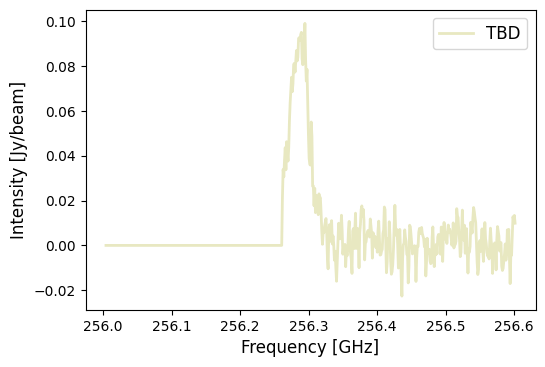

In [6]:
## Useful function #####################################################
# plot spectra

# fit spectra (to derive centroid velocity)


## Major flow of data analysis #########################################

# Open FITS image cube
fitscubename = '/home/tcc/DATA/GC_Dspecies/ancillary/H29alpha_7m+12m_natural.image.fits'
myAnalysis = spectraAna(fitscubename = fitscubename)
myAnalysis.readfits(verbose = True)
ypix = 523
xpix = 425
intensity_array =  myAnalysis.Ihdu[0].data[0][:, ypix, xpix]

naxis3     = myAnalysis.naxis3
crpix3     = myAnalysis.crpix3
cdelt3     = myAnalysis.cdelt3
crval3     = myAnalysis.crval3 
freq_array = np.zeros( naxis3 )
freq_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3

print(freq_array)
plot_spectra( freq_array/1e9, intensity_array )

# Loop over all spatial pixels and fit the centroid velocity
myAnalysis.get_velocity(verbose = True)

# Output the 2D centroid-velocity map (?)
myAnalysis.write_velocity()

# Based on the 2D centroid-velocity map to un-redshift/blueshift spectra
myAnalysis.unrbshift_spectra()

# stack spectra
myAnalysis.stack_spectra()


This is the program to read FITS image cube
Reading FITS image cube :/home/tcc/DATA/GC_Dspecies/ancillary/H29alpha_7m+12m_natural.image.fits
(583,)
31 324


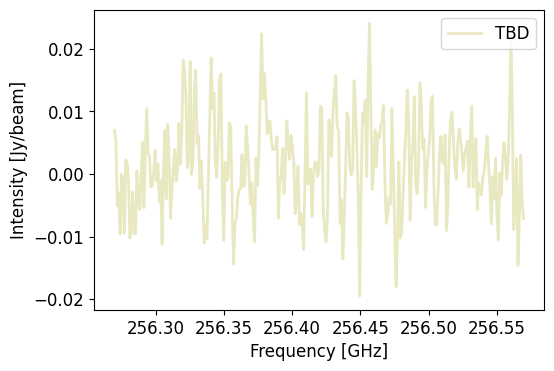

In [14]:
# Open FITS image cube
fitscubename = '/home/tcc/DATA/GC_Dspecies/ancillary/H29alpha_7m+12m_natural.image.fits'
myAnalysis = spectraAna(fitscubename = fitscubename)
myAnalysis.readfits(verbose = True)
ypix = 495
xpix = 425
intensity_array =  myAnalysis.Ihdu[0].data[0][:, ypix, xpix]


naxis3     = myAnalysis.naxis3
crpix3     = myAnalysis.crpix3
cdelt3     = myAnalysis.cdelt3
crval3     = myAnalysis.crval3 
freq_array = np.zeros( naxis3 )
freq_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3

print(np.shape(freq_array))


freqGHz_start = 256.57
freqGHz_end   = 256.27

freq_startpix = round( ( freqGHz_start*1e9 - crval3 )/cdelt3 + crpix3 )
freq_endpix = round( ( freqGHz_end*1e9 - crval3 )/cdelt3 + crpix3 )

print(freq_startpix, freq_endpix)

# print(freq_array)
plot_spectra( freq_array[freq_startpix:freq_endpix]/1e9, intensity_array[freq_startpix:freq_endpix])


In [15]:
## calculate the standard deviation as measurement errors (y_err)
std = np.std(intensity_array[freq_startpix:freq_endpix])
print(std)

0.0073789516
